## Data Analysis & Visualization Using Yahoo Finance.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import mplfinance as mpf
import datetime as dt`

In [2]:
# (2) download the last year of price information for TSLA & S&P 500

ticker_name = 'SPY'
yticker = yf.Ticker(ticker_name)
mkt = yticker.history(period="1y")

ticker_name = 'TSLA'
yticker = yf.Ticker(ticker_name)
tsla = yticker.history(period="1y")

In [3]:
# Compute log returns

mkt['Return'] = np.log(mkt['Close']/mkt['Close'].shift(1))
tsla['Return'] = np.log(tsla['Close']/tsla['Close'].shift(1))

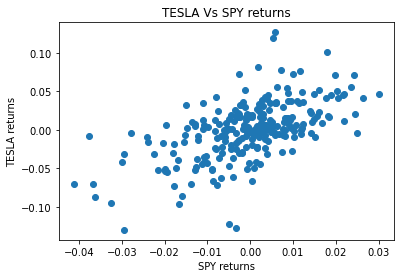

In [6]:
# (3) Scatter Plot

fig1, ax1 = plt.subplots()
plt.scatter(mkt['Return'], tsla['Return'])
plt.title('TESLA Vs SPY returns')
plt.xlabel('SPY returns')
plt.ylabel('TESLA returns')
plt.show()

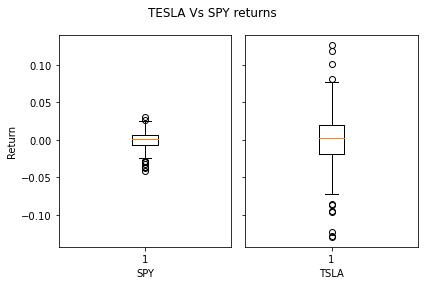

In [7]:
# (5) box plots

fig2, ax2 = plt.subplots(1, 2, sharey=True, tight_layout=True)
ax2[0].boxplot(mkt['Return'].values[1:])
ax2[1].boxplot(tsla['Return'].values[1:])
ax2[0].set(xlabel="SPY", ylabel="Return")
ax2[1].set(xlabel="TSLA")
plt.suptitle('TESLA Vs SPY returns')
plt.show()

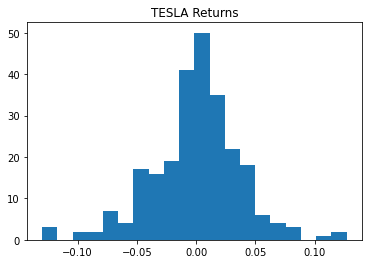

In [8]:
# (4) histogram

plt.hist(tsla['Return'], bins =20)
plt.title('TESLA Returns')
plt.show()

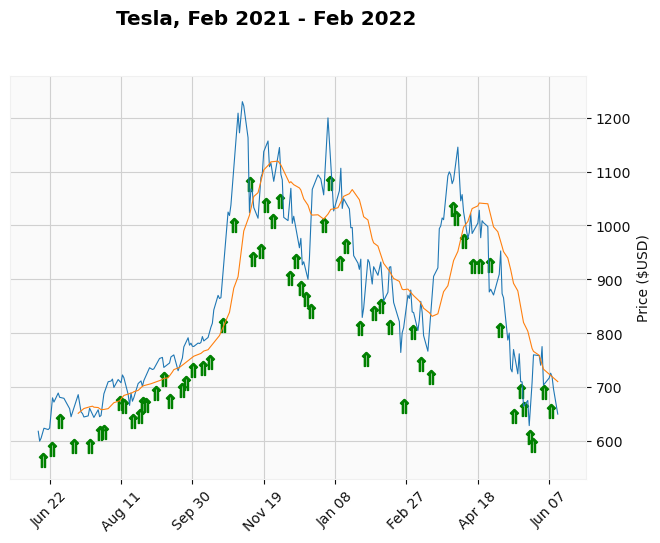

In [9]:
# (6) Plot a mav indicator alongside the stock price - to flag buy/sell signals.

ticker_name = 'TSLA'
yticker = yf.Ticker(ticker_name)
data = yticker.history(period="1y")
data.drop(columns=data.columns[-2:], axis= 1, inplace= True) #drop last two empty columns

buy = np.where((data['Close'] > data['Open']) & \
               (data['Close'].shift(1) < data['Open'].shift(1)), 1, np.nan) \
                * 0.95 * data['Low']

adpl = [mpf.make_addplot(buy, scatter=True, markersize=100, marker=r'$\Uparrow$', color='green')]

mpf.plot(data, type='line', style='yahoo', 
         title='Tesla, Feb 2021 - Feb 2022',
         ylabel='Price ($USD)',
         show_nontrading=True,
         datetime_format='%b %d',
         mav= 20,
         addplot = adpl
         )

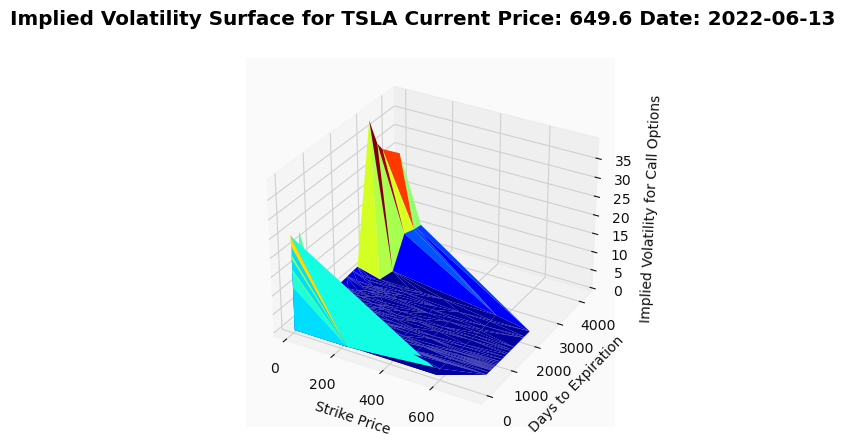

In [10]:
# (7) Pull option data from yahoo finance 

def options_chain(TSLA):

    tk = yf.Ticker('TSLA')
    exps = tk.options
    options = pd.DataFrame()
  
    for e in exps:
        opt = tk.option_chain(e)
        opt = pd.DataFrame().append(opt.calls).append(opt.puts)
        opt['expirationDate'] = e
        options = options.append(opt, ignore_index=True)

    options['expirationDate'] = \
    pd.to_datetime(options['expirationDate']) + dt.timedelta(days = 1)
    options['dte'] = (options['expirationDate'] - dt.datetime.today()).dt.days

    options['CALL'] = options['contractSymbol'].str[4:].apply(lambda x: "C" in x)

    options[['bid', 'ask', 'strike']] = \
    options[['bid', 'ask', 'strike']].apply(pd.to_numeric) 
    options['mark'] = (options['bid'] + options['ask']) / 2

    options = \
    options.drop(columns = ['contractSize', 'currency', 'change', 'percentChange', \
                            'lastTradeDate', 'lastPrice'])
    
    return options

# (7) 3D implied volatility surface

ticker_name = 'TSLA'
yticker = yf.Ticker(ticker_name)
tsla = yticker.history(period="1y") 
oc = options_chain(ticker_name)

oc = oc[(oc.volume > 10) & (oc.CALL == True) ]

xaxis=oc['dte'] 
yaxis=oc['strike']
zaxis=oc['impliedVolatility']
fig4 = plt.figure(2)
ax = fig4.add_subplot(111, projection='3d')
ax.plot_trisurf(xaxis, yaxis, zaxis, cmap=plt.cm.jet)
ax.set_xlabel('Strike Price')
ax.set_ylabel('Days to Expiration')
ax.set_zlabel('Implied Volatility for Call Options')
plt.suptitle('Implied Volatility Surface for %s Current Price: %s Date: %s' %
(ticker_name, '{0:.4g}'.format(tsla['Close'].values[-1]), dt.date.today()))

plt.show()